In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np;
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
import matplotlib as mlp
from matplotlib import pyplot as plt
import seaborn as sns
import stopwords
from textblob import TextBlob

In [40]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
stop_words = set(stopwords.get_stopwords('english'))
lemmatizer = WordNetLemmatizer()

In [29]:
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def get_sentiment(text):
    blob = TextBlob(text)
    # Get the polarity score
    polarity = blob.sentiment.polarity
    # Determine the sentiment based on the polarity score
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'
    
def preprocess_text(text):
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

    
def contains_emoji(text):
    # check if the text contains any emojis
    return any(char in emoji.UNICODE_EMOJI['en'] for char in text)

def clean_review(text):
    # remove "VERIFIED" and "NOT VERIFIED" (case insensitive)
    text = re.sub(r'(verified|not verified)', '', text, flags=re.IGNORECASE)
    # remove the "|" character
    text = re.sub(r'\|', '', text)
    # remove mentions, special characters, hashtags, and URLs
    text = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", "", text)
    # remove any extra spaces that might result from the removal
    text = ' '.join(text.split())
    return text

To start off, we scrap 10000 revies off airlinequality.com for British Airlines.

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 100
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Now that we have the dataset, we can take a look and see what it looks like.

In [6]:
df = pd.read_csv('data/reviews.csv', index_col=0)
df


,reviews
0,✅ Trip Verified | If you can’t fly First Class...
1,Not Verified | Singapore to Heathrow. Busine...
2,Not Verified | I reported my damaged/ruined ...
3,"Not Verified | On March 1st, I flew from Ber..."
4,Not Verified | The WORST customer experience! ...
...,...
3820,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...
3821,LHR to HAM. Purser addresses all club passenge...
3822,My son who had worked for British Airways urge...
3823,London City-New York JFK via Shannon on A318 b...


A first look of the dataset tells us that it only has one column that contains the customer reviews about the airline. Next we need to check if the dataset contains any duplicates or missing values.

## Data Cleaning and Preparation


### Removing Duplicates

In [8]:
duplicates = df.duplicated(subset=['reviews'])
# total number of duplicates found
duplicate_count = duplicates.sum()
null_count = df.isnull().sum()
null_count

reviews    0
dtype: int64

Next, we prepare the data using the following steps:
 - Clean the reviews by removing the 'VERIFIED | NOT VERIFIED' text and any special characters it may contain.
 - Create a new column containing the tokens of each review. Tokens in NLP are basically individual words without any stopwords. Tokens are useful for text computing word frequencies, identifying key terms, part-speech tagging, named entity recognition, sentiment analysis and more.
 - Create a new column containing the sentiment of each review.

In [10]:
df['reviews_clean'] = df.apply(lambda x:clean_review(x['reviews'].lower()), axis=1)
df['preprocessed_review'] = df['reviews_clean'].apply(preprocess_text)
df['sentiment'] = df['preprocessed_review'].apply(lambda x: get_sentiment(x))


In [11]:
df

,reviews,reviews_clean,preprocessed_review,sentiment
0,✅ Trip Verified | If you can’t fly First Class...,trip if you cant fly first class dont fly brit...,trip cant fly first class dont fly british air...,negative
1,Not Verified | Singapore to Heathrow. Busine...,singapore to heathrow business class on an a38...,singapore heathrow business class a380800 prem...,negative
2,Not Verified | I reported my damaged/ruined ...,i reported my damagedruined suitcase 5 weeks a...,reported damagedruined suitcase 5 week ago im ...,negative
3,"Not Verified | On March 1st, I flew from Ber...",on march 1st i flew from berlin to são paulo w...,march 1st flew berlin são paulo ba encountered...,negative
4,Not Verified | The WORST customer experience! ...,the worst customer experience british airways ...,worst customer experience british airway ba ef...,positive
...,...,...,...,...
3820,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...,lhrhkg on boeing 747 230812 much has been writ...,lhrhkg boeing 747 230812 much written tired ol...,positive
3821,LHR to HAM. Purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr ham purser address club passenger name boa...,positive
3822,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,son worked british airway urged fly british ai...,positive
3823,London City-New York JFK via Shannon on A318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon a318 reall...,positive


# Data Analysis

In [13]:
import streamlit as st
import seaborn

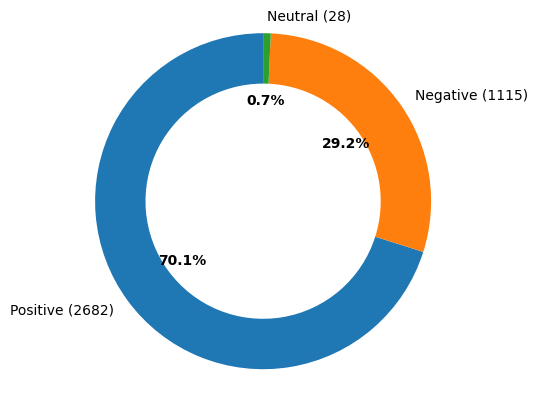

In [14]:
palette_color = seaborn.color_palette('bright') 


  
counts = df['sentiment'].value_counts()

# prepare labels with counts and percentages
labels = [f'{label} ({count})' for label, count in zip(['Positive', 'Negative', 'Neutral'], counts)]
sizes = counts.values

palette_color = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, ax = plt.subplots()

# plot pie chart with percentage and count in labels, and make it a donut chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    colors=palette_color, 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops=dict(width=0.3) 
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

ax.axis('equal')

plt.show()

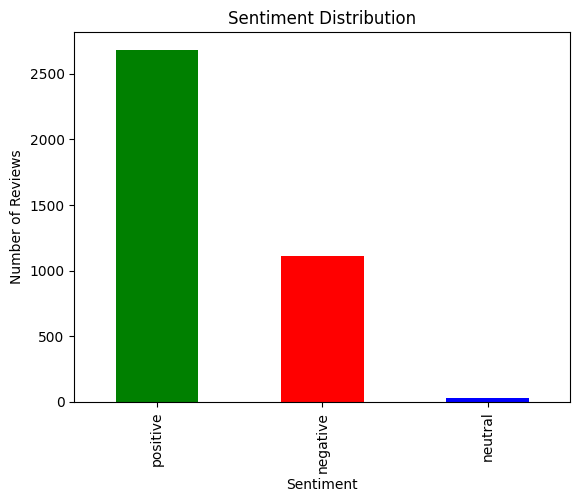

In [15]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

From the above charts, we can see that the majority of British Airline customers have happy while 29.2% are unhappy with BA services. Only 0.7% are neutral. Next, we look at the overall sentiment distribution. Next, we plot the word clouds for both positive and negative reviews.

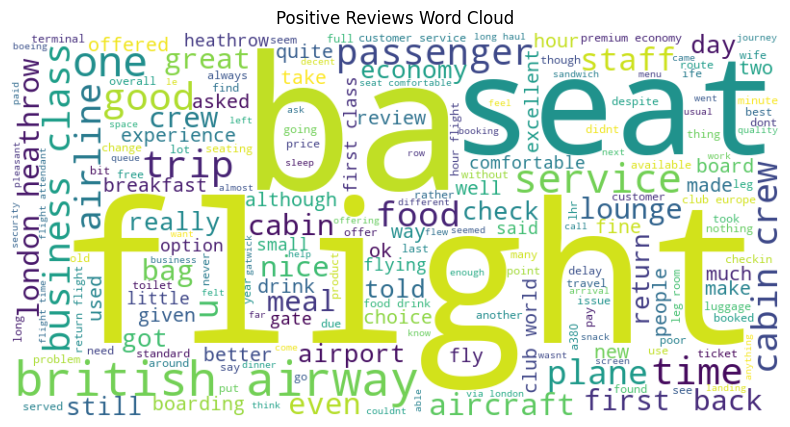

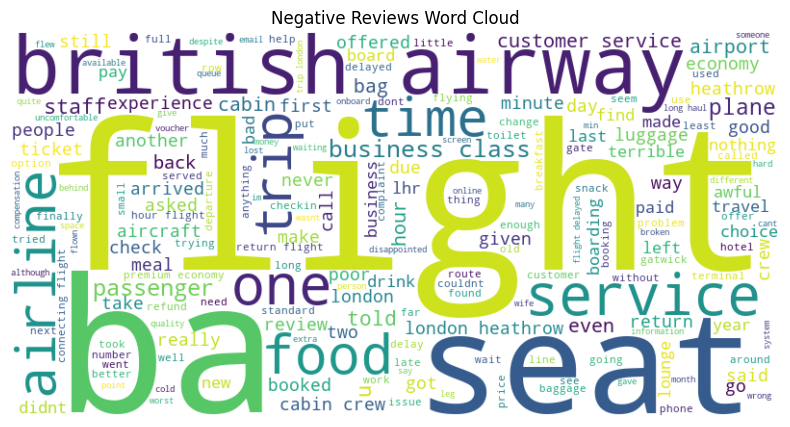

In [94]:
from wordcloud import WordCloud

# word cloud for positive reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['preprocessed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

# word cloud for negative reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['preprocessed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

From the above word clouds , we can infer that both positive and negative reviewws frequently mention `flight`, `seat` and `service`, indicating these are critical aspects of the passenger experience that can greatly influence overall satistication. Positive reviews are mostly characterized by words like `good`, `great`, `comfortable`, and `excellent`, while the negative reviews frequently use words like `terrible`, `awful`, `poor` and `bad`. Negative reviews specifically highlight issued related to `delays`, `luggage` and `customer service`, while positive reviews emphasize `good service`, `comfortable seating` and pleasant `staff interactions`.



# Topic Extraction

We can do further analysis by extracting topics for both positive and negative reviews.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# vectorize the preprocessed reviews
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df[df['sentiment'] == 'positive']['preprocessed_review'])

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# display the top words in each topic
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")

Topics for positive reviews for British Airways reveals several key areas of passenger satisfaction. Passengers appreciate the cabin environment and crew service, particularly praising the quality of in-flight meals and overall service. Business class travelers highlight their positive experiences and the general service provided by the airline. Reviews also indicate a positive travel experience related to time management and scheduling. Lounge services, the quality of food, and overall crew service are highly appreciated, especially in premium areas like clubs. Additionally, passengers express long-term satisfaction with the airline, particularly in economy class, noting good value and quality over the years.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# vectorize the preprocessed reviews
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df[df['sentiment'] == 'negative']['preprocessed_review'])

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# display the top words in each topic
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")

Top words for topic #0:
['seat', 'service', 'aircraft', 'ba', 'hour', 'meal', 'cabin', 'drink', 'food', 'flight']


Top words for topic #1:
['london', 'trip', 'cabin', 'airline', 'hour', 'staff', 'service', 'ba', 'seat', 'flight']


Top words for topic #2:
['airline', 'club', 'economy', 'service', 'food', 'flight', 'ba', 'seat', 'business', 'class']


Top words for topic #3:
['day', 'time', 'london', 'service', 'airway', 'british', 'customer', 'hour', 'ba', 'flight']


Top words for topic #4:
['service', 'airline', 'choice', 'ba', 'airway', 'cabin', 'british', 'food', 'flight', 'seat']




Both positive and negative reviews seem to contain simillar topics which suggests that the differing experiences relate to simillar aspects of British Airline services. This means that aspecs like `Seat and Cabin Comfort`, `Service Quality`, `Food and Meals`, `Flight Experience and Timing`, and  `Economy and Business classes` are the main areas that impact the overall passenger experience. British Airways should focus on consistently improving these critical aspects. By addressing the negative feedback and maintaining the positive aspects, the airline can work towards providing a more uniform and high quality experience for all passengers.

Next, for further analysis, we will extract the top 10 most common bigrams(2 words) for both positive and negative reviews.

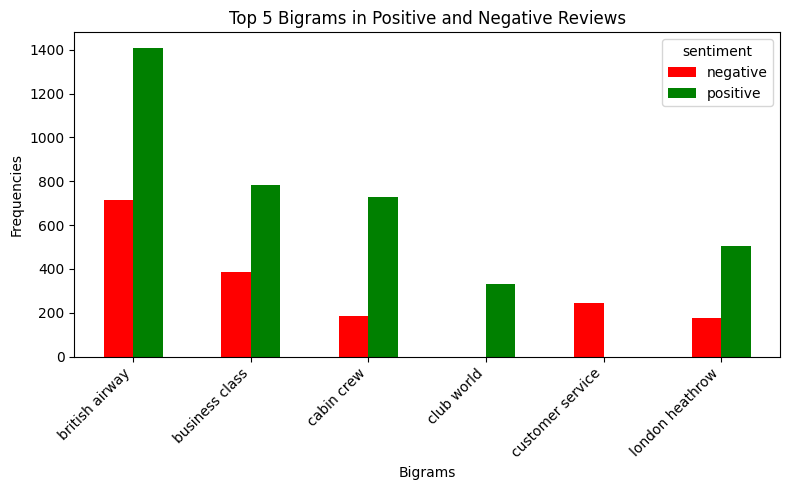

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Extract bigrams for positive reviews
vectorizer_pos = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_pos = vectorizer_pos.fit_transform(df[df['sentiment'] == 'positive']['preprocessed_review'])
bigrams_pos = vectorizer_pos.get_feature_names_out()
bigram_counts_pos = X_pos.toarray().sum(axis=0)
bigram_freq_pos = dict(zip(bigrams_pos, bigram_counts_pos))
sorted_bigrams_pos = sorted(bigram_freq_pos.items(), key=lambda x: x[1], reverse=True)

# Extract bigrams for negative reviews
vectorizer_neg = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_neg = vectorizer_neg.fit_transform(df[df['sentiment'] == 'negative']['preprocessed_review'])
bigrams_neg = vectorizer_neg.get_feature_names_out()
bigram_counts_neg = X_neg.toarray().sum(axis=0)
bigram_freq_neg = dict(zip(bigrams_neg, bigram_counts_neg))
sorted_bigrams_neg = sorted(bigram_freq_neg.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame for the top 5 bigrams from both positive and negative reviews
top_bigrams_pos = sorted_bigrams_pos[:5]
top_bigrams_neg = sorted_bigrams_neg[:5]

# Combine the data into a DataFrame
combined_bigrams = pd.DataFrame({
    'bigram': [bigram[0] for bigram in top_bigrams_pos] + [bigram[0] for bigram in top_bigrams_neg],
    'frequency': [bigram[1] for bigram in top_bigrams_pos] + [bigram[1] for bigram in top_bigrams_neg],
    'sentiment': ['positive'] * len(top_bigrams_pos) + ['negative'] * len(top_bigrams_neg)
})

# Pivot the DataFrame for plotting
pivot_df = combined_bigrams.pivot(index='bigram', columns='sentiment', values='frequency').fillna(0)

# Plot the bar chart
pivot_df.plot(kind='bar', figsize=(8, 5), color=['red', 'green'])
plt.xlabel('Bigrams')
plt.ylabel('Frequencies')
plt.title('Top 5 Bigrams in Positive and Negative Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


The bigram frequency distribution chart shows us the top aspects of Birtish Airways that contribute to the majority of positive and negative experiences. This could simply mean that customers on average have a positive experience but some customer experiences seem to negative about the simillar aspects of the travel experience. 

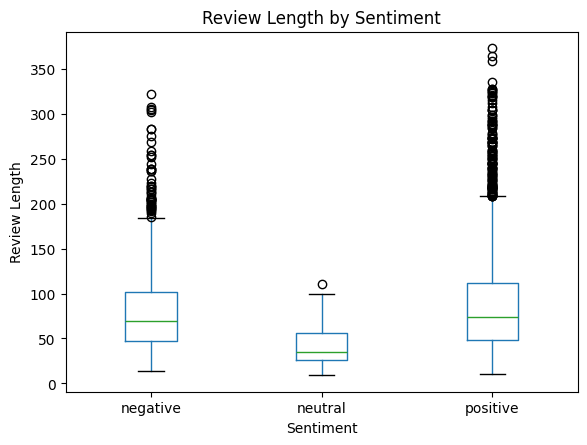

In [26]:
df['review_length'] = df['preprocessed_review'].apply(lambda x: len(x.split()))
df.boxplot(column='review_length', by='sentiment', grid=False)
plt.title('Review Length by Sentiment')
plt.suptitle('')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

Finally, the box plot of review length shows that that on average negative and positive reviews are simillar in length ranging from ~50 to a little over 100 words with positive reviews being slightly larger. Neutral reviews seem to be very short on average containing about 50 words.